# Optymalizacja hiperparametrów modelu kNN (Grid Search)

W tym notatniku przeprowadzimy automatyczne poszukiwanie najlepszych parametrów dla algorytmu k-Najbliższych Sąsiadów (kNN). 
Sprawdzimy wpływ:
- Liczby sąsiadów (`k`)
- Metryki odległości (`euclidean` vs `manhattan`)
- Sposobu głosowania (`uniform` vs `distance`)

Na końcu wygenerujemy wykres pokazujący, jak te parametry wpływają na dokładność modelu.

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# 1. Konfiguracja ścieżek i import modułów projektu
project_root = Path('..').resolve()
sys.path.insert(0, str(project_root / 'src'))
from ml_pipeline import GenericScikitLearner

# Konfiguracja wykresów
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

print(f"📂 Project Root: {project_root}")

📂 Project Root: /app


## 1. Wczytanie Danych Treningowych

In [5]:
# ==========================================
# POPRAWIONA KOMÓRKA WCZYTYWANIA DANYCH
# ==========================================
print("📂 Wczytywanie danych...")
data_processed = project_root / 'data' / 'processed'
train_path = data_processed / 'train_features.csv'

if train_path.exists():
    train_df = pd.read_csv(train_path)
    
    # --- NAPRAWA DANYCH (FIX) ---
    # Funkcja czyszcząca: zamienia stringi "[123.45]" na float 123.45
    def clean_numeric_value(value):
        if isinstance(value, str) and value.startswith('[') and value.endswith(']'):
            try:
                return float(value.strip('[]'))
            except ValueError:
                return value
        return value

    # Przeiteruj po wszystkich kolumnach i napraw te, które wyglądają na listy
    print("🧹 Czyszczenie danych z błędnych formatów (np. nawiasy w CSV)...")
    for col in train_df.columns:
        if train_df[col].dtype == 'object' and col not in ['genre', 'filename']:
            train_df[col] = train_df[col].apply(clean_numeric_value)
            # Próba konwersji kolumny na numeric po czyszczeniu
            try:
                train_df[col] = pd.to_numeric(train_df[col])
            except:
                pass
    # -----------------------------

    # Przygotowanie X i y
    X_train = train_df.drop(['genre', 'filename'], axis=1)
    y_train = train_df['genre']

    # Upewnij się, że mamy tylko liczby (na wypadek gdyby coś jeszcze zostało)
    X_train = X_train.select_dtypes(include=[np.number])

    print(f"✅ Dane treningowe wczytane i naprawione: {X_train.shape}")
    
    # Sprawdzenie czy nie ma pustych wartości
    if X_train.isnull().values.any():
        print("⚠️ Znaleziono puste wartości (NaN). Uzupełniam zerami.")
        X_train = X_train.fillna(0)
        
else:
    print("❌ Brak pliku train_features.csv! Uruchom najpierw scripts/prepare_datasets.py")

📂 Wczytywanie danych...
🧹 Czyszczenie danych z błędnych formatów (np. nawiasy w CSV)...
✅ Dane treningowe wczytane i naprawione: (600, 44)


## 2. Konfiguracja Grid Search
Definiujemy przestrzeń parametrów, którą chcemy przeszukać. Używamy naszego wrappera `GenericScikitLearner`, aby zapewnić poprawną standaryzację danych wewnątrz każdej pętli walidacji.

In [6]:
# Inicjalizacja wrappera z domyślnym kNN
base_knn = KNeighborsClassifier()
model_wrapper = GenericScikitLearner(base_knn, name="knn")

# Siatka parametrów do sprawdzenia
# Klucze muszą odnosić się do nazw kroków w pipeline (zdefiniowanych w GenericScikitLearner)
param_grid = {
    'knn__n_neighbors': range(1, 31),         # Sprawdzamy k od 1 do 30
    'knn__weights': ['uniform', 'distance'],  # Sposób głosowania
    'knn__metric': ['euclidean', 'manhattan'] # Sposób mierzenia odległości
}

print("🔧 Konfiguracja Grid Search gotowa.")
print(f"   Liczba kombinacji: {len(param_grid['knn__n_neighbors']) * len(param_grid['knn__weights']) * len(param_grid['knn__metric'])}")

🔧 Konfiguracja Grid Search gotowa.
   Liczba kombinacji: 120


## 3. Uruchomienie Obliczeń
To może chwilę potrwać. `GridSearchCV` używa walidacji krzyżowej (CV=5), więc każdy model jest trenowany i oceniany 5 razy.

In [7]:
print("\n🔍 Rozpoczynanie Grid Search (to może chwilę potrwać)...")

grid_search = GridSearchCV(
    estimator=model_wrapper.pipeline, # Używamy pipeline'u z naszego wrappera
    param_grid=param_grid,
    cv=5,                             # 5-krotna walidacja krzyżowa
    scoring='accuracy',               # Optymalizujemy pod kątem dokładności
    n_jobs=-1,                        # Użyj wszystkich rdzeni procesora
    verbose=1,
    return_train_score=False
)

grid_search.fit(X_train, y_train)
print("✅ Zakończono przeszukiwanie.")


🔍 Rozpoczynanie Grid Search (to może chwilę potrwać)...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
✅ Zakończono przeszukiwanie.


## 4. Analiza i Wizualizacja Wyników

In [8]:
# Konwersja wyników do DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Wyciągamy interesujące nas kolumny i zmieniamy ich nazwy na czytelniejsze
viz_df = results_df[[
    'param_knn__n_neighbors', 
    'param_knn__weights', 
    'param_knn__metric', 
    'mean_test_score'
]].copy()

viz_df.columns = ['k', 'Weights', 'Metric', 'Accuracy']

# Tworzymy kolumnę pomocniczą do legendy (łączenie Metric + Weights)
viz_df['Configuration'] = viz_df['Metric'] + ' + ' + viz_df['Weights']

# Wyświetl top 5 wyników
display(viz_df.sort_values('Accuracy', ascending=False).head(5))

,k,Weights,Metric,Accuracy,Configuration
67,4,distance,manhattan,0.631667,manhattan + distance
65,3,distance,manhattan,0.618333,manhattan + distance
73,7,distance,manhattan,0.616667,manhattan + distance
83,12,distance,manhattan,0.615000,manhattan + distance
75,8,distance,manhattan,0.613333,manhattan + distance


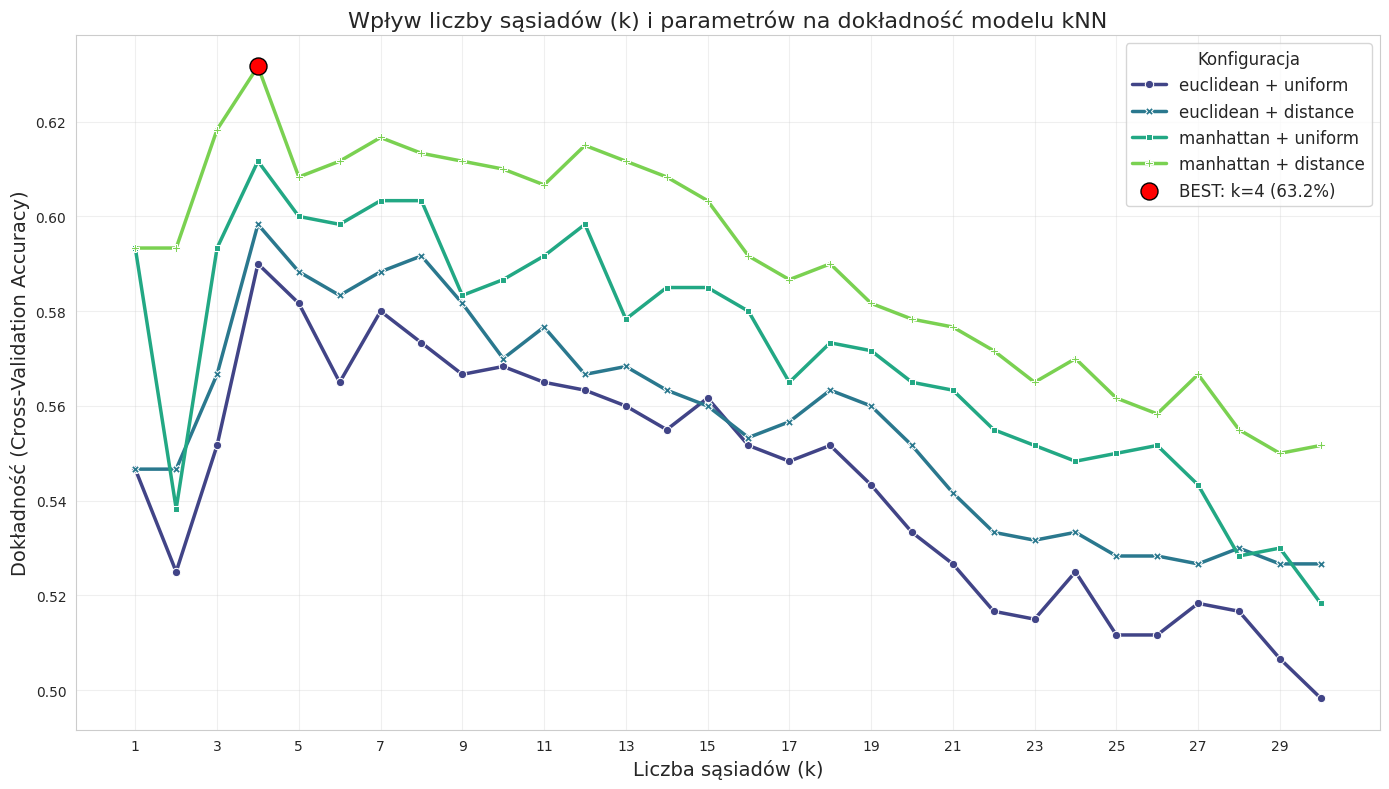

In [9]:
# Rysowanie wykresu
plt.figure(figsize=(14, 8))

sns.lineplot(
    data=viz_df,
    x='k',
    y='Accuracy',
    hue='Configuration', # Różne kolory dla różnych konfiguracji
    style='Configuration', # Różne style linii
    markers=True,
    dashes=False,
    linewidth=2.5,
    palette='viridis'
)

# Oznaczenie najlepszego punktu na wykresie
best_row = viz_df.loc[viz_df['Accuracy'].idxmax()]
plt.scatter(
    best_row['k'], 
    best_row['Accuracy'], 
    color='red', s=150, zorder=5, edgecolors='black', 
    label=f"BEST: k={best_row['k']} ({best_row['Accuracy']:.1%})"
)

plt.title('Wpływ liczby sąsiadów (k) i parametrów na dokładność modelu kNN', fontsize=16)
plt.xlabel('Liczba sąsiadów (k)', fontsize=14)
plt.ylabel('Dokładność (Cross-Validation Accuracy)', fontsize=14)
plt.legend(title='Konfiguracja', fontsize=12, title_fontsize=12)
plt.xticks(range(1, 31, 2)) # Podziałka osi X co 2
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

⏳ Obliczam krzywą walidacji dla n_neighbors...


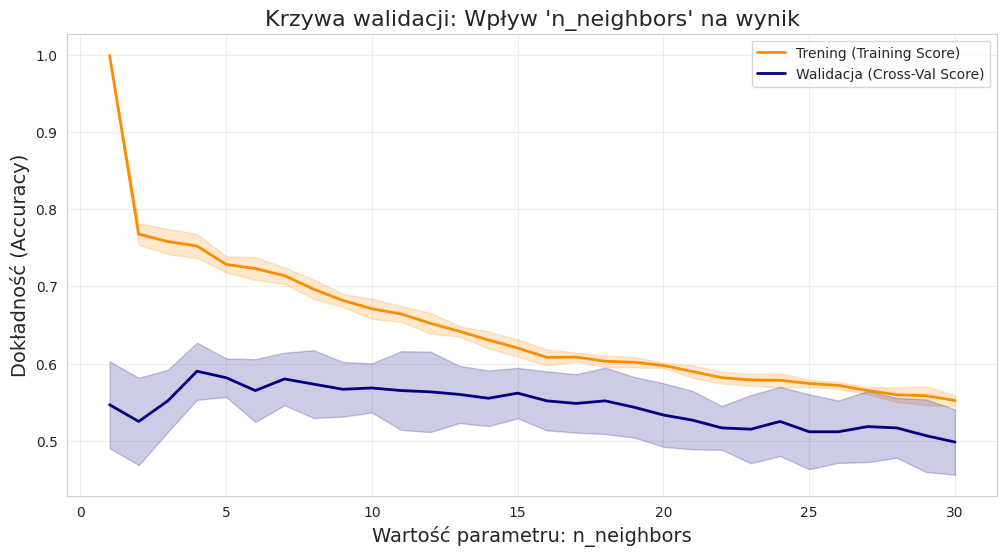

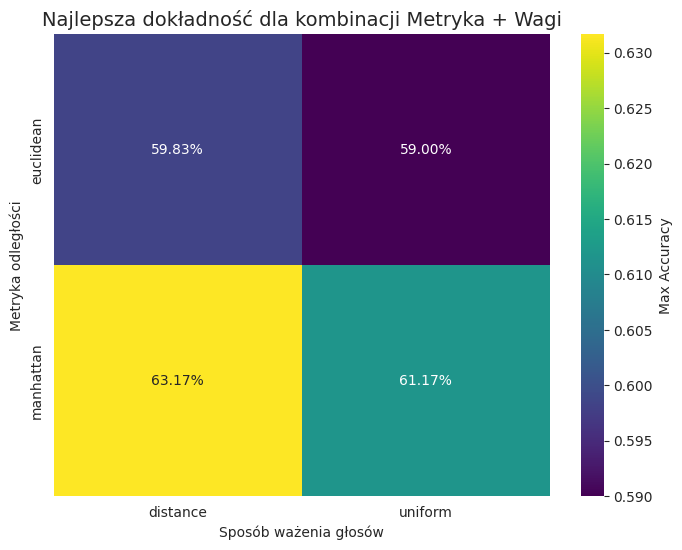

In [16]:
# ==============================================================================
# WIZUALIZACJE OPTYMALIZACJI (Wklej do knn_optimization.ipynb)
# ==============================================================================
from sklearn.model_selection import validation_curve

# 1. Funkcja rysująca Krzywą Walidacji (Complexity Curve)
def plot_complexity_curve(X, y, param_name, param_range):
    print(f"⏳ Obliczam krzywą walidacji dla {param_name}...")
    
    # Tworzymy nową instancję pipeline'u do testów
    # Upewniamy się, że używamy samej instancji Pipeline, nie wrappera, bo validation_curve tego wymaga
    # Zakładamy, że X zawiera już tylko kolumny numeryczne (co zrobiliśmy wcześniej w notatniku)
    estimator = GenericScikitLearner(KNeighborsClassifier(), name="knn").pipeline
    
    train_scores, test_scores = validation_curve(
        estimator, 
        X, y, 
        param_name=f"knn__{param_name}", 
        param_range=param_range,
        cv=5, 
        scoring="accuracy", 
        n_jobs=-1
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(12, 6))
    plt.plot(param_range, train_mean, label="Trening (Training Score)", color="darkorange", lw=2)
    plt.plot(param_range, test_mean, label="Walidacja (Cross-Val Score)", color="navy", lw=2)

    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color="darkorange")
    plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.2, color="navy")

    plt.title(f"Krzywa walidacji: Wpływ '{param_name}' na wynik", fontsize=16)
    plt.xlabel(f"Wartość parametru: {param_name}", fontsize=14)
    plt.ylabel("Dokładność (Accuracy)", fontsize=14)
    plt.legend(loc="best")
    plt.grid(True, alpha=0.3)
    plt.show()

# --- URUCHOMIENIE WIZUALIZACJI ---

# A. Rysowanie Krzywej Walidacji dla liczby sąsiadów (k)
# Upewnij się, że X_train i y_train są zdefiniowane (z poprzednich komórek)
if 'X_train' in locals() and 'y_train' in locals():
    plot_complexity_curve(X_train, y_train, "n_neighbors", range(1, 31))
else:
    print("❌ Brak zmiennych X_train/y_train. Uruchom wcześniejsze komórki.")

# B. Rysowanie Heatmapy (Metryka vs Wagi)
# Wymaga DataFrame 'viz_df' z poprzednich kroków Grid Search
if 'viz_df' in locals():
    heatmap_data = viz_df.groupby(['Metric', 'Weights'])['Accuracy'].max().unstack()
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap_data, annot=True, fmt=".2%", cmap="viridis", cbar_kws={'label': 'Max Accuracy'})
    plt.title("Najlepsza dokładność dla kombinacji Metryka + Wagi", fontsize=14)
    plt.ylabel("Metryka odległości")
    plt.xlabel("Sposób ważenia głosów")
    plt.show()
else:
    print("❌ Brak zmiennej viz_df. Uruchom Grid Search.")

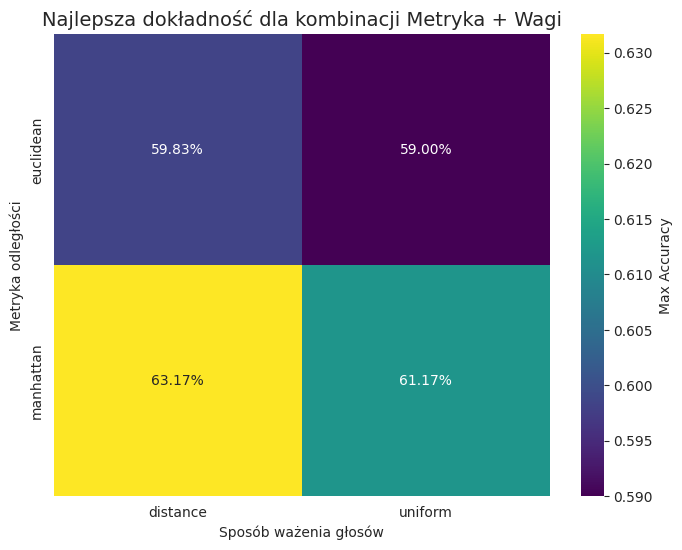

In [14]:
# Kod do knn_optimization.ipynb (po wykonaniu grid_search)

# Agregacja wyników dla heatmapy (bierzemy najlepsze k dla danej pary metric+weights)
heatmap_data = viz_df.groupby(['Metric', 'Weights'])['Accuracy'].max().unstack()

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2%", cmap="viridis", cbar_kws={'label': 'Max Accuracy'})
plt.title("Najlepsza dokładność dla kombinacji Metryka + Wagi", fontsize=14)
plt.ylabel("Metryka odległości")
plt.xlabel("Sposób ważenia głosów")
plt.show()

## 5. Podsumowanie

In [13]:
print("\n🏆 Najlepsze znalezione parametry:")
print(f"   • k (Liczba sąsiadów): {grid_search.best_params_['knn__n_neighbors']}")
print(f"   • Wagi (Weights):      {grid_search.best_params_['knn__weights']}")
print(f"   • Metryka (Metric):    {grid_search.best_params_['knn__metric']}")
print(f"   • Średnia dokładność:  {grid_search.best_score_:.2%}")

print("\n💡 Wskazówka: Możesz użyć tych parametrów w pliku scripts/train_knn.py dla lepszych wyników!")


🏆 Najlepsze znalezione parametry:
   • k (Liczba sąsiadów): 4
   • Wagi (Weights):      distance
   • Metryka (Metric):    manhattan
   • Średnia dokładność:  63.17%

💡 Wskazówka: Możesz użyć tych parametrów w pliku scripts/train_knn.py dla lepszych wyników!
